In [131]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

#### constants definition

In [132]:
horizon = 480 #5 days, 15-min intervals
dt = 0.25 # hours per time slot (15 min ⇒ 0.25 h)

#DATA LOADING-----------------------------------------------------------------
#demand
factor_profil_demand = 50000/1000000 # factor for profil demand scaling
#pv
PV_area = 200 # m²
PV_efficiency = 0.2 # 20% efficiency
#price
base_price = 22.16/100 #in CHF/kWh with TVA
peak_price = 32.52/100 #in CHF/kWh with TVA

#MODELING--------------------------------------------------------------------
#ev
num_evs      = 15         # number of EVs
P_rated      = 4.0         # kW, max charger power
E_req        = 6.0         # kWh, daily depleted energy of 6 kWh per EV
slots_per_day= 96          # total 15-min slots per day
num_days     = 5           # number of days
start_idx    = 9 * 4       # 9:00 → slot 36
end_idx      = 18 * 4      # 18:00 → slot 72 (exclusive upper bound)
evs = range(num_evs) 
slots = range(slots_per_day)
days = range(num_days)

#AMM
n_AMM = 5 # number of AM machines
AMM = range(n_AMM)
power_AMM = 2.76  # Power consumption of each printer in kW
D = 16 # Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)

#heating
COP_h = 2.5                      # Heating COP
COP_c = 2.5                      # Cooling COP
inertia = 0.98                   # Inertia factor ϵ
A_th = 2.0                       # Thermal conductivity [kW/°C]
T_desired = 19.0                 # Setpoint temperature [°C]
dead_band = 2.0                  # ± dead-band [°C]
T_lower = T_desired - dead_band  # Lower comfort limit (17°C)
T_upper = T_desired + dead_band  # Upper comfort limit (21°C)
T_0 = T_lower                    # Initial indoor temperature (set here at the lower bound, can be modified)


#### models definition

In [133]:
model1 = gp.Model("ADR") # Scenario 1: Dynamic pricing  + PV generation
model2 = gp.Model("ADR") # Scenario 2: Dynamic pricing  + NO-PV generation
model3 = gp.Model("ADR") # Scenario 3: BasePeak pricing + PV generation
model4 = gp.Model("ADR") # Scenario 4: BasePeak pricing + NO-PV generation

## Data Loading

### Electricity demand

In [134]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
real_Demand= profile_demand['Demand']*factor_profil_demand
Critical_Demand= np.array(real_Demand)

#plot the Demand Column
# plt.plot(real_Demand)
# plt.title('Demand Profile')
# plt.xlabel('Time Interval')
# plt.ylabel('Demand [kWh]')
# plt.show()


### Electricity price loading

In [135]:
spot_prices = pd.read_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv',parse_dates=['time'],index_col='time')# we should change spot_prices for dyn_prices
spot_prices['price'] = spot_prices['price'] / 100 #conversion from cts/kWh to CHF/kWh

#create an array called Base_Peak_price where price from 7 to 21 is Peak Price and base otherwise 
start = spot_prices.index[0]
rng = pd.date_range(start, periods=horizon, freq='15T')
prices = [ peak_price if 7 <= ts.hour < 21 else base_price for ts in rng ]

Base_Peak_price_df = (pd.DataFrame({'price': prices}, index=rng) ) #dataframe with price for printing correctly

# plt.figure(figsize=(12, 4))
# plt.plot(spot_prices.index, spot_prices['price'],label='Spot Price')
# plt.plot(Base_Peak_price_df.index, Base_Peak_price_df['price'], label='Base/Peak Price', color='red')

# plt.title('Prices(15 min) of GroupE VarioPlus and Bease/Peak option — 7 to 11 Apr 2019')
# plt.xlabel('Time Interval')
# plt.ylabel('Price [CHF/kWh]')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

spot_prices = np.array(spot_prices['price']) # convert to an array
Base_Peak_prices = np.array(Base_Peak_price_df['price'])

C:\Users\arthu\AppData\Local\Temp\ipykernel_39108\3298532162.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range(start, periods=horizon, freq='15T')


### Temperature loading

In [136]:
# import and display Temperature_Data_Zurich_15min.csv
temperature_data = pd.read_csv('Temperature_Data_Zurich_15min.csv', parse_dates=['time'])
# Plot the temperature (°C) at 15-minute intervals
# plt.figure(figsize=(12, 4))
# plt.plot(temperature_data.index, temperature_data['temperature'], color='blue')
# plt.title('Temperature in Zurich (7–11 April 2019, 15-min resolution)')
# plt.xlabel('Date and Time')
# plt.ylabel('Temperature [°C]')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### Solar irradiance

In [137]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv') #kWh/m²
PV_energy = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh
PV_power = PV_energy / dt # kW, *4 = dt^(-1) pour l avoir en kW. 
PV_power = np.array(PV_power)

# Plot the solar energy (kWh) at 15-minute intervals
# plt.figure(figsize=(12, 4))
# plt.plot(solar_energy.index, PV_power, color='green')
# plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
# plt.xlabel('Date and Time')
# plt.ylabel('Energy [kW]')
# plt.grid(True)
# plt.tight_layout()
# plt.show()  

## Modelling 

### EVs:

In [138]:
def ev_modeling(price, model, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated):
    # index sets
    slots_per_day = 96
    # continuous variable p_ev[e,d,t] ∈ [0, P_rated] = charging power of EV e in slot t (kW)
    p_ev = model.addVars(evs, days, slots, #create set of decision variables, indexed by EVs, time slots and day
                #each variable p_ev[e,d, t] corresponds to the charging power of EV e on day d during time slot t in kW
                vtype=GRB.CONTINUOUS,
                lb=0.0, # lower bound of the variable
                ub=P_rated, # upper bound of the variable, P_rated is the maximum charging power
                name="p_ev") #base name of the variable

    # 1) Energy requirement: each EV must accumulate E_req kWh over the allowed window
    for e in evs:
        for d in days :
            model.addConstr( gp.quicksum(p_ev[e,d,t] * dt for t in range(start_idx, end_idx)) == E_req,  name=f"energy_e{e}_d{d}")

    # 2) Enforce zero charging outside [9:00,18:00), each day.
    for e in evs:
        for d in days:
            # before 9:00
            for t in range(0, start_idx):
                model.addConstr(p_ev[e,d,t] == 0, name=f"zero_before_e{e}_d{d}_t{t}")
            # after 18:00
            for t in range(end_idx, slots_per_day):
                model.addConstr(p_ev[e,d,t] == 0, name=f"zero_after_e{e}_d{d}_t{t}")

    # 3) Total cost of charging: 
    total_cost_EV = gp.LinExpr() #important to define the total cost as a gurobi linear expression!

    for e in evs:
        for d in days:
            for t in slots:
                index = d * slots_per_day + t  # flat index into spot_price
                total_cost_EV += p_ev[e, d, t] * price[index] * dt

    return total_cost_EV, p_ev


### Additive Manufacturing (AM) Machines

In [139]:

def AM_modeling(price, model, n_AMM, power_AMM, horizon, D):

    AMM = range(n_AMM) # index set for AM machines

    # Decision variable, x[m,t] = 1 if machine m starts a job at time t
    x = model.addVars(n_AMM,horizon,vtype=GRB.BINARY,name='start')

    # Prevent overlapping jobs on the same machine: Ensures machine m can't start two jobs too close together
    for m in AMM:
        for t1 in range(horizon - D + 1):
            for t2 in range(t1 + 1, min(t1 + D, horizon - D + 1)):
                model.addConstr(x[m, t1] + x[m, t2] <= 1,
                                name=f"no_overlap_m{m}_t{t1}_t{t2}")

    # Last feasible time to start

    # Every week, 47 pieces must be produced
    model.addConstr(
        gp.quicksum(x[m, t] for m in AMM for t in range(horizon - D + 1)) >= 47,
        name="min_production")

    # Add a power constraint for every time slot t using only x as indicator.
    running = model.addVars(horizon, vtype=GRB.CONTINUOUS, name='running')
    for t in range(horizon):
        running[t]= gp.quicksum(
            x[m, s]
            for m in AMM
            for s in range(max(0, t - D + 1), min(t + 1, horizon - D + 1)))

    # total cost of the AM machines
    cost_AMM = gp.quicksum(x[m, t] * sum(price[t] for t in range(t,t+D)) * power_AMM * dt for m in AMM for t in range(horizon - D + 1))
    
    return cost_AMM, running,x


### Heating demand

In [140]:

def Heating_Cooling_modeling(price, model, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out):
    # Define working hours mask (09:00–18:00); T_set is used only to indicate working hours
    mask_work = (temperature_data['time'].dt.hour >= 9) & (temperature_data['time'].dt.hour < 18)
    T_set = np.full(horizon, np.nan)
    T_set[mask_work.values] = T_desired

    # Compute effective heating and cooling coefficients:
    alpha_h = (1 - inertia) * (COP_h / A_th)   # Effect of additional heating
    alpha_c = (1 - inertia) * (COP_c / A_th)   # Effect of additional cooling

    # Decision variables:
    # Define p_h for heating power and p_c for cooling power.
    # Here, the space heater is sized at 40 kW; you might set a similar bound for cooling.
    p_h = model.addVars(horizon, lb=0.0, ub=40.0, name="p_heat")
    p_c = model.addVars(horizon, lb=0.0, ub=40.0, name="p_cool")

    # Indoor temperature state variables:
    T_in = model.addVars(horizon, lb=-GRB.INFINITY, name="T_in")
    model.addConstr(T_in[0] == T_0, name="init_temp")

    # Thermal dynamics constraint:
    # T_in[k+1] = inertia * T_in[k] + (1 - inertia) * T_out[k] + (alpha_h * p_h[k]) - (alpha_c * p_c[k])
    for k in range(horizon-1):
        model.addConstr(
            T_in[k+1] == inertia * T_in[k] + (1 - inertia) * T_out[k] + alpha_h * p_h[k] - alpha_c * p_c[k],
            name=f"dyn_{k}")

    # Comfort constraints (only enforced during working hours):
    # Ensure that T_in stays within [T_lower, T_upper] (i.e. within ±2°C of 19°C)
    for k in range(horizon):
        if not np.isnan(T_set[k]):
            model.addConstr(T_in[k] >= T_lower, name=f"min_comfort_{k}")
            model.addConstr(T_in[k] <= T_upper, name=f"max_comfort_{k}")

    # Energy consumption of the heating and cooling systems using spot prices
    cost_HC = gp.quicksum((p_h[k] + p_c[k]) * dt * price[k] for k in range(horizon))
    return cost_HC,p_h,p_c,T_in


### PV

In [141]:
def PV_modeling(scenario, horizon, PV_power, price):
    # Total "cost" (profit) of PV
    cost_PV = gp.LinExpr()
    if (scenario == 1) or (scenario == 3):
        for t in range(horizon):
            cost_PV += (-1) * PV_power[t] * price[t] # CHF
    else: 
        cost_PV = 0
    return cost_PV

### Power threslhold

In [142]:
def power_threshold(scenario, model, p_ev, ph, pc, running, horizon, num_days, slots_per_day, PV_power):
    slots_per_day = 96
    for t in range(horizon):
        # Determine corresponding day and slot, but using tht time index t of the for loop. 
        d = t // slots_per_day #computes the day number, donne le quotient de la division entière
        s = t % slots_per_day #computes the time slot number , donne le modulo de la division entière

        # EV power at time t
        if d < num_days and s < slots_per_day:
            ev_power_t = gp.quicksum(p_ev[e, d, s] for e in evs)
        else:
            ev_power_t = 0  # safeguard, shouldn't happen

        # AM power: already aggregated in 'running[t]' variable (continuous)
        am_power_t = power_AMM * running[t]

        # Heating power at time t
        heating_power_t = ph[t] + pc[t]

        pv_power_t = PV_power[t]

        # Total power must stay below 20 kW
        if (scenario == 1) or (scenario == 3):
            model.addConstr( ev_power_t + am_power_t + heating_power_t - pv_power_t <= 20, name=f"power_limit_t{t}")
        else:
            model.addConstr( ev_power_t + am_power_t + heating_power_t  <= 20, name=f"power_limit_t{t}")
        

### Objective function

In [143]:
def objective_function(prices, Critical_Demand,cost_AMM, cost_HC,total_cost_EV,cost_PV):
        # Add a constant term to the model objective: models the critical appliances
    total_cost_critical = gp.LinExpr() #important to define the total cost as a gurobi linear expression!
    
    for t in range(480):
        total_cost_critical += Critical_Demand[t] * prices[t]
    total_cost_week = total_cost_EV + cost_AMM + cost_HC + total_cost_critical + cost_PV
    
    return total_cost_week, total_cost_critical

#### Optimization
il faut diviser en 4 appel distincts

In [144]:
#Calling the EV's modeling 
total_cost_EV_1, p_ev_1 = ev_modeling(spot_prices, model1, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)
total_cost_EV_2, p_ev_2 = ev_modeling(spot_prices, model2, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)
total_cost_EV_3, p_ev_3 = ev_modeling(Base_Peak_prices, model3, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)
total_cost_EV_4, p_ev_4 = ev_modeling(Base_Peak_prices, model4, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)

# Calling the AMM modeling 
cost_AMM_1,running_1,x_1 = AM_modeling(spot_prices,model1, n_AMM, power_AMM, horizon, D)
cost_AMM_2,running_2,x_2 = AM_modeling(spot_prices,model2, n_AMM, power_AMM, horizon, D)
cost_AMM_3,running_3,x_3 = AM_modeling(Base_Peak_prices,model3, n_AMM, power_AMM, horizon, D)
cost_AMM_4,running_4,x_4 = AM_modeling(Base_Peak_prices,model4, n_AMM, power_AMM, horizon, D)

# Calling the Heating demand modeling 
# Use the outside temperature from your temperature_data; ensure the ordering/matching with time steps.
T_out = temperature_data['temperature'].values

cost_HC_1, ph_1, pc_1, T_in_1 = Heating_Cooling_modeling(spot_prices, model1, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)
cost_HC_2, ph_2, pc_2, T_in_2 = Heating_Cooling_modeling(spot_prices, model2, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)
cost_HC_3, ph_3, pc_3, T_in_3 = Heating_Cooling_modeling(Base_Peak_prices, model3, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)
cost_HC_4, ph_4, pc_4, T_in_4 = Heating_Cooling_modeling(Base_Peak_prices, model4, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_1 = PV_modeling(1, horizon, PV_power, spot_prices)
cost_PV_2 = PV_modeling(2, horizon, PV_power, spot_prices)# will be equal to 0
cost_PV_3 = PV_modeling(3, horizon, PV_power, Base_Peak_prices)
cost_PV_4 = PV_modeling(4, horizon, PV_power, Base_Peak_prices)# will be equal top 0

# Calling the Power threshold 
power_threshold(1,model1, p_ev_1, ph_1, pc_1, running_1, horizon,num_days, slots_per_day, PV_power)
power_threshold(2,model2, p_ev_2, ph_2, pc_2, running_2, horizon,num_days, slots_per_day, PV_power)
power_threshold(3,model3, p_ev_3, ph_3, pc_3, running_3, horizon,num_days, slots_per_day, PV_power)
power_threshold(4,model4, p_ev_4, ph_4, pc_4, running_4, horizon,num_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_1,total_cost_critical_1 = objective_function(spot_prices, Critical_Demand,cost_AMM_1, cost_HC_1,total_cost_EV_1, cost_PV_1)
total_cost_week_2,total_cost_critical_2 = objective_function(spot_prices, Critical_Demand,cost_AMM_2, cost_HC_2,total_cost_EV_2, cost_PV_2)
total_cost_week_3,total_cost_critical_3 = objective_function(Base_Peak_prices, Critical_Demand,cost_AMM_3, cost_HC_3,total_cost_EV_3, cost_PV_3)
total_cost_week_4,total_cost_critical_4 = objective_function(Base_Peak_prices, Critical_Demand,cost_AMM_4, cost_HC_4,total_cost_EV_4, cost_PV_4)

In [145]:
#Calling the EV's modeling 
total_cost_EV_1, p_ev_1 = ev_modeling(spot_prices, model1, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)

# Calling the AMM modeling 
cost_AMM_1,running_1,x_1 = AM_modeling(spot_prices,model1, n_AMM, power_AMM, horizon, D)

# Calling the Heating demand modeling 
cost_HC_1, ph_1, pc_1, T_in_1 = Heating_Cooling_modeling(spot_prices, model1, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_1 = PV_modeling(1, horizon, PV_power, spot_prices)

# Calling the Power threshold 
power_threshold(1,model1, p_ev_1, ph_1, pc_1, running_1, horizon,num_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_1,total_cost_critical_1 = objective_function(spot_prices, Critical_Demand,cost_AMM_1, cost_HC_1,total_cost_EV_1, cost_PV_1)

model1.setObjective(total_cost_week_1, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model1.write('out.lp')
model1.optimize()


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2648242 - for non-commercial use only - registered to ad___@ethz.ch
Optimize a model with 80342 rows, 23040 columns and 251424 nonzeros
Model fingerprint: 0xe0c7526f
Variable types: 18240 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 74364 rows and 10809 columns
Presolve time: 0.14s
Presolved: 5978 rows, 12231 columns, 166329 nonzeros
Variable types: 7581 continuous, 4650 integer (4650 binary)
Performing another presolve...
Presolve removed 3111 rows and 8661 columns
Presolve time: 0.41s

Root relaxation: objective 7.386975e+01, 1412 iterations, 0

In [146]:
#Calling the EV's modeling 
total_cost_EV_2, p_ev_2 = ev_modeling(spot_prices, model2, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)

# Calling the AMM modeling 
cost_AMM_2,running_2,x_2 = AM_modeling(spot_prices,model2, n_AMM, power_AMM, horizon, D)

# Calling the Heating demand modeling 
cost_HC_2, ph_2, pc_2, T_in_2 = Heating_Cooling_modeling(spot_prices, model2, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_2 = PV_modeling(2, horizon, PV_power, spot_prices)# will be equal to 0

# Calling the Power threshold 
power_threshold(2,model2, p_ev_2, ph_2, pc_2, running_2, horizon,num_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_2,total_cost_critical_2 = objective_function(spot_prices, Critical_Demand,cost_AMM_2, cost_HC_2,total_cost_EV_2, cost_PV_2)

model2.setObjective(total_cost_week_2, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model2.write('out.lp')
model2.optimize()


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2648242 - for non-commercial use only - registered to ad___@ethz.ch
Optimize a model with 80342 rows, 23040 columns and 251424 nonzeros
Model fingerprint: 0x21d7c18f
Variable types: 18240 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 74364 rows and 10809 columns
Presolve time: 0.13s
Presolved: 5978 rows, 12231 columns, 166329 nonzeros
Variable types: 7581 continuous, 4650 integer (4650 binary)
Performing another presolve...
Presolve removed 3111 rows and 8661 columns
Presolve time: 0.40s

Root relaxation: objective 6.830971e+02, 1822 iterations, 0

In [147]:
#Calling the EV's modeling 
total_cost_EV_3, p_ev_3 = ev_modeling(Base_Peak_prices, model3, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)

# Calling the AMM modeling 
cost_AMM_3,running_3,x_3 = AM_modeling(Base_Peak_prices,model3, n_AMM, power_AMM, horizon, D)

# Calling the Heating demand modeling 
cost_HC_3, ph_3, pc_3, T_in_3 = Heating_Cooling_modeling(Base_Peak_prices, model3, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_3 = PV_modeling(3, horizon, PV_power, Base_Peak_prices)

# Calling the Power threshold 
power_threshold(3,model3, p_ev_3, ph_3, pc_3, running_3, horizon,num_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_3,total_cost_critical_3 = objective_function(Base_Peak_prices, Critical_Demand,cost_AMM_3, cost_HC_3,total_cost_EV_3, cost_PV_3)

model3.setObjective(total_cost_week_3, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model3.write('out.lp')
model3.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2648242 - for non-commercial use only - registered to ad___@ethz.ch
Optimize a model with 80342 rows, 23040 columns and 251424 nonzeros
Model fingerprint: 0xd74b5f6f
Variable types: 18240 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  Objective range  [6e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 74364 rows and 10809 columns
Presolve time: 0.14s
Presolved: 5978 rows, 12231 columns, 166329 nonzeros
Variable types: 7581 continuous, 4650 integer (4650 binary)
Performing another presolve...
Presolve removed 3206 rows and 8755 columns
Presolve time: 0.38s

Root relaxation: objective 5.722013e+01, 1007 iterations, 0

In [148]:
#Calling the EV's modeling 
total_cost_EV_4, p_ev_4 = ev_modeling(Base_Peak_prices, model4, evs, days, slots, dt, start_idx, end_idx, E_req, P_rated)

# Calling the AMM modeling 
cost_AMM_4,running_4,x_4 = AM_modeling(Base_Peak_prices,model4, n_AMM, power_AMM, horizon, D)

# Calling the Heating demand modeling 
cost_HC_4, ph_4, pc_4, T_in_4 = Heating_Cooling_modeling(Base_Peak_prices, model4, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_4 = PV_modeling(4, horizon, PV_power, Base_Peak_prices)# will be equal top 0

# Calling the Power threshold 
power_threshold(4,model4, p_ev_4, ph_4, pc_4, running_4, horizon,num_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_4,total_cost_critical_4 = objective_function(Base_Peak_prices, Critical_Demand,cost_AMM_4, cost_HC_4,total_cost_EV_4, cost_PV_4)
model4.setObjective(total_cost_week_4, GRB.MINIMIZE)

# Solve the model, i.e. minimize the cost
model4.write('out.lp')
model4.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2648242 - for non-commercial use only - registered to ad___@ethz.ch
Optimize a model with 80342 rows, 23040 columns and 251424 nonzeros
Model fingerprint: 0x6a71bafd
Variable types: 18240 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  Objective range  [6e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 74364 rows and 10809 columns
Presolve time: 0.14s
Presolved: 5978 rows, 12231 columns, 166329 nonzeros
Variable types: 7581 continuous, 4650 integer (4650 binary)
Performing another presolve...
Presolve removed 3206 rows and 8755 columns
Presolve time: 0.39s

Root relaxation: objective 7.217058e+02, 1041 iterations, 0

### Plots

In [149]:
def print_consumption(scenario, model, p_ev, x, p_h, p_c, AMM, days, power_AMM, total_cost_EV, cost_AMM, cost_HC, total_cost_critical, cost_PV):# call to model unecessary I think
    
    ## ENERGY CONSUMPTION CALCULATION BY CATEGORY
    total_energy_kWh = 0.0

    # EV charging
    energy_ev = sum(p_ev[e, d, t].X * dt for e in evs for d in days for t in slots)
    total_energy_kWh += energy_ev

    # AM machines
    energy_am = sum(x[m, t].X * power_AMM * D * dt for m in AMM for t in range(horizon - D + 1))
    total_energy_kWh += energy_am

    # Heating and cooling
    energy_heat = sum(p_h[k].X * dt for k in range(horizon))
    energy_cool = sum(p_c[k].X * dt for k in range(horizon))
    total_energy_kWh += energy_heat + energy_cool

    # Critical appliances (already in kWh)
    energy_critical = np.sum(Critical_Demand)
    total_energy_kWh += energy_critical

    # Final output
    print(f" Total energy consumed during the week: {total_energy_kWh:.2f} kWh")
    print(f"  - EV Charging:     {energy_ev:.2f} kWh")
    print(f"  - AM Machines:     {energy_am:.2f} kWh")
    print(f"  - Heating:         {energy_heat:.2f} kWh")
    print(f"  - Cooling:         {energy_cool:.2f} kWh")
    print(f"  - Critical Loads:  {energy_critical:.2f} kWh")

    if (scenario == 1) or (scenario == 3) :
        print(f"  - PV Energy:       CHF {cost_PV.getValue():.2f}") 
    print(f"  -----------------------------")

    ## PRICE CALCULATION BY CATEGORY
    print(" Weekly Cost Breakdown (CHF):")
    print(f"  - EV Charging:     CHF {total_cost_EV.getValue():.2f}")
    print(f"  - AM Machines:     CHF {cost_AMM.getValue():.2f}")
    print(f"  - Heating/Cooling: CHF {cost_HC.getValue():.2f}")
    print(f"  - Critical Loads:  CHF {total_cost_critical.getValue():.2f}")
    print(f"  -----------------------------")
    print(f"  Total Costs from Objective function: CHF {model.ObjVal:.2f}\n")


In [150]:
print("Scenario 1:")
print_consumption(1, model1, p_ev_1, x_1, ph_1, pc_1, AMM, days, power_AMM, total_cost_EV_1, cost_AMM_1, cost_HC_1, total_cost_critical_1, cost_PV_1)
print("Scenario 2:")
print_consumption(2, model2, p_ev_2,x_2,ph_2,pc_2,AMM,days, power_AMM,total_cost_EV_2,cost_AMM_2,cost_HC_2,total_cost_critical_2,cost_PV_2)

Scenario 1:
 Total energy consumed during the week: 2533.84 kWh
  - EV Charging:     450.00 kWh
  - AM Machines:     518.88 kWh
  - Heating:         770.29 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  - PV Energy:       CHF -578.84
  -----------------------------
 Weekly Cost Breakdown (CHF):
  - EV Charging:     CHF 104.11
  - AM Machines:     CHF 115.39
  - Heating/Cooling: CHF 207.71
  - Critical Loads:  CHF 225.53
  -----------------------------
  Total Costs from Objective function: CHF 73.91

Scenario 2:
 Total energy consumed during the week: 2526.80 kWh
  - EV Charging:     450.00 kWh
  - AM Machines:     518.88 kWh
  - Heating:         763.24 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Weekly Cost Breakdown (CHF):
  - EV Charging:     CHF 108.17
  - AM Machines:     CHF 134.65
  - Heating/Cooling: CHF 214.87
  - Critical Loads:  CHF 225.53
  -----------------------------
  Total Costs from Objective 

In [151]:
print("Scenario 3:")
print_consumption(3, model3, p_ev_3,x_3,ph_3,pc_3,AMM,days, power_AMM,total_cost_EV_3,cost_AMM_3,cost_HC_3,total_cost_critical_3,cost_PV_3)
print("Scenario 4:")
print_consumption(4, model4, p_ev_4,x_4,ph_4,pc_4,AMM,days, power_AMM,total_cost_EV_4,cost_AMM_4,cost_HC_4,total_cost_critical_4,cost_PV_4)

Scenario 3:
 Total energy consumed during the week: 2517.91 kWh
  - EV Charging:     450.00 kWh
  - AM Machines:     518.88 kWh
  - Heating:         754.35 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  - PV Energy:       CHF -660.89
  -----------------------------
 Weekly Cost Breakdown (CHF):
  - EV Charging:     CHF 146.34
  - AM Machines:     CHF 115.56
  - Heating/Cooling: CHF 214.55
  - Critical Loads:  CHF 241.66
  -----------------------------
  Total Costs from Objective function: CHF 57.22

Scenario 4:
 Total energy consumed during the week: 2531.45 kWh
  - EV Charging:     450.00 kWh
  - AM Machines:     518.88 kWh
  - Heating:         767.90 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Weekly Cost Breakdown (CHF):
  - EV Charging:     CHF 146.34
  - AM Machines:     CHF 115.84
  - Heating/Cooling: CHF 217.89
  - Critical Loads:  CHF 241.66
  -----------------------------
  Total Costs from Objective 

la fonction si dessous ne me parait pas essentielle donc j'ai pas encore pris le temps de la modifier

In [152]:
# print values of the decision variable 

print("x[m,t]:")
#m=0
i=0
#initialize an empty list of dimension (1,20)
time_travel = np.zeros(20) # Initialize an array to store the time values

for m in AMM:
    for t in range(horizon):
        if x[m, t].X > 0.5:  # If the variable is 1 (or close to it)
            print(f"Machine {m} starts at time {t}: {x[m, t].X}")
        #time_travel[i] = t
            i += 1

# Print the time_travel array
print("Time travel array:", time_travel)

# Print the values of the decision variable x at m=1 and t=8
print("x[1,8]:", x[1, 8].X)

x[m,t]:


NameError: name 'x' is not defined

In [ ]:
def Energy_consumption_plot(scenario, T_in, pc, ph, x, p_ev, num_evs, days, num_days, slots_per_day, horizon):# Access EV charging schedule
    ev_power_schedule = np.zeros((num_evs, num_days, slots_per_day))
    for e in range(num_evs):
        for d in range(num_days):
            for t in range(slots_per_day):
                ev_power_schedule[e, d, t] = p_ev[e, d, t].X #.X is used to access the value of the variable after optimization

    # Access AM machine start schedule
    am_schedule = np.zeros((n_AMM, horizon))
    for m in AMM:
        for t in range(horizon):
            am_schedule[m, t] = x[m, t].X

    # Access heating and cooling power
    p_heat = np.array([ph[k].X for k in range(horizon - 1)])
    p_cool = np.array([pc[k].X for k in range(horizon - 1)])

    # Indoor temperature trajectory
    T_indoor = np.array([T_in[k].X for k in range(horizon)])

    # 1. Flatten EV charging: sum over all EVs at each time step
    ev_total_power = np.zeros(horizon)
    for d in days:
        for t in range(slots_per_day):
            index = d * slots_per_day + t
            ev_total_power[index] = np.sum(ev_power_schedule[:, d, t])  # sum over EVs

    # 2. AM machine profile: add 2.76 kW for 16 slots whenever x[m, t] == 1
    power_AMM = 2.76
    D = 16  # 4 hours = 16 slots
    am_power = np.zeros(horizon)
    for m in AMM:
        for t in range(horizon - D + 1):
            if am_schedule[m, t] > 0.5:
                am_power[t:t + D] += power_AMM

    # 3. Heating power (already extracted)
    p_heating = np.append(p_heat, 0.0)  # pad to full 480

    # 4. Total energy consumption (kW)
    total_power = ev_total_power + am_power + p_heating

    # 6. Time axis
    time_axis = np.arange(horizon) * dt  # in hours (0 to 120)

    plt.figure(figsize=(16, 14))

    # 1. Total energy consumption
    plt.subplot(6, 1, 1)
    plt.plot(time_axis, total_power, label='Total Demand (kW)', color='black')
    plt.ylabel('kW')
    plt.title(f'Total Energy Consumption for Scenario {scenario}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Scenario 1:


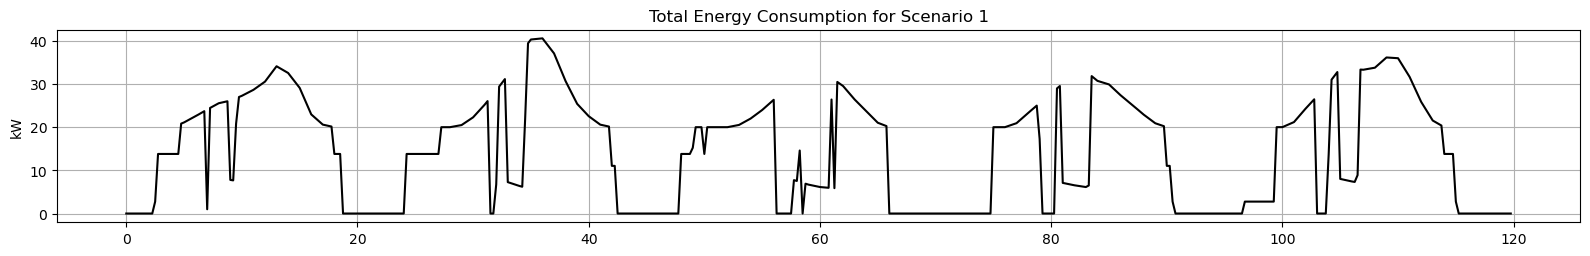

In [ ]:
print("Scenario 1:")
Energy_consumption_plot(1, T_in_1, pc_1, ph_1, x_1, p_ev_1, num_evs, days, num_days, slots_per_day, horizon)

Scenario 2:


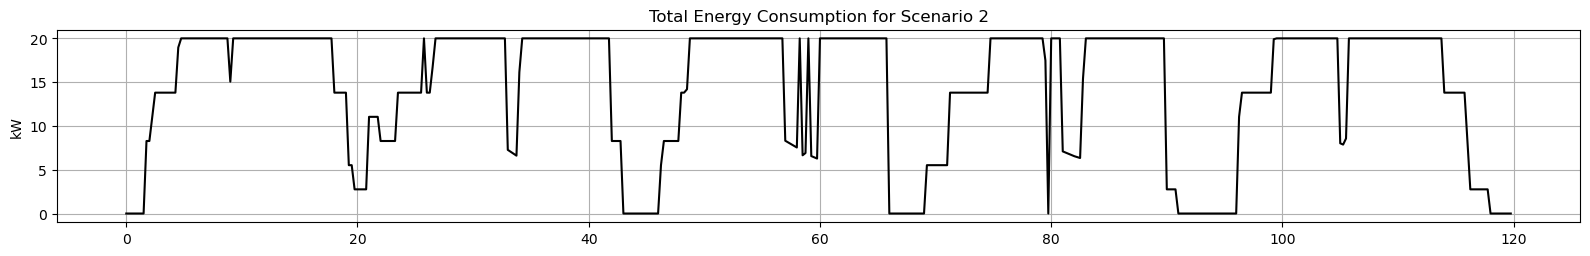

In [ ]:
print("Scenario 2:")
Energy_consumption_plot(2, T_in_2, pc_2, ph_2, x_2, p_ev_2, num_evs, days, num_days, slots_per_day, horizon)

Scenario 3:


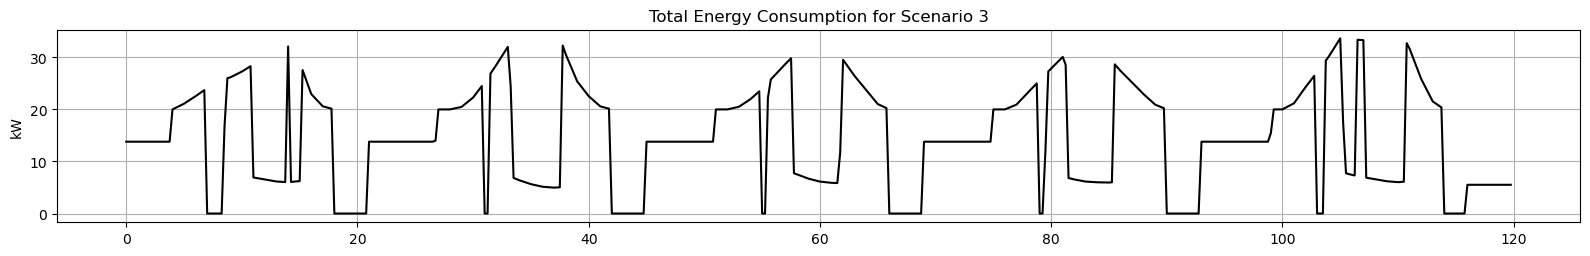

In [ ]:
print("Scenario 3:")
Energy_consumption_plot(3, T_in_3, pc_3, ph_3, x_3, p_ev_3, num_evs, days, num_days, slots_per_day, horizon)

Scenario 4:


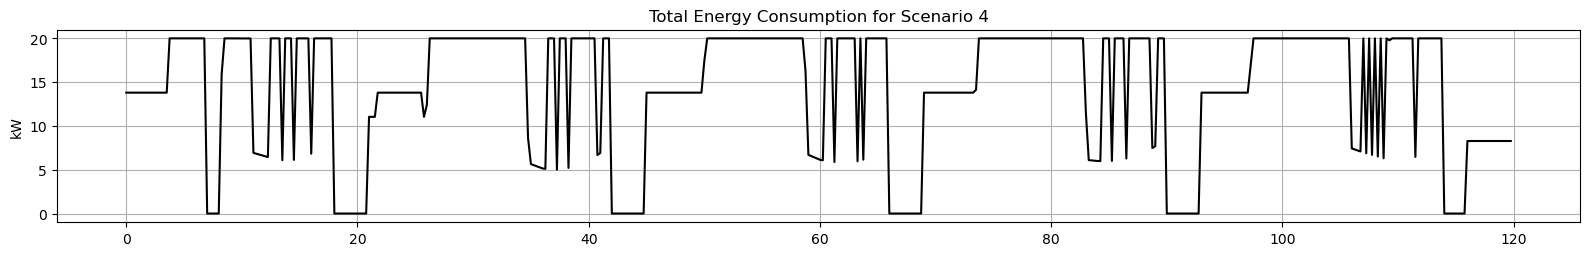

In [ ]:
print("Scenario 4:")
Energy_consumption_plot(4, T_in_4, pc_4, ph_4, x_4, p_ev_4, num_evs, days, num_days, slots_per_day, horizon)

In [ ]:

def detailed_plots(scenario, T_in,p_ev,pc, ph, x, days, slots_per_day, n_AMM, AMM, horizon, num_evs):# Extract the values of the decision variables
    p_values = np.zeros((num_evs, num_days, slots_per_day))
    for e in range(num_evs):
        for d in range(num_days):
            for t in range(slots_per_day):
                p_values[e, d, t] = p_ev[e, d, t].X

    x_values = np.zeros((n_AMM, horizon))
    for m in AMM:
        for t in range(horizon):
            x_values[m, t] = x[m, t].X

    p_h_values = np.zeros(horizon-1)
    for k in range(horizon-1):
        p_h_values[k] = ph[k].X

    p_c_values = np.zeros(horizon-1)
    for k in range(horizon-1):
        p_c_values[k] = pc[k].X

    T_in_values = np.zeros(horizon)
    for k in range(horizon):
        T_in_values[k] = T_in[k].X
    T_out_values = np.zeros(horizon)
    for k in range(horizon):
        T_out_values[k] = T_out[k]

    # Plot the results

    #EV Plotting
    # Create time axis (0 to 120 hours in 15-min resolution)
    time_axis = np.arange(96 * 5) * 0.25  # 480 time steps

    # Create a 2D array: 15 EVs × 480 time steps
    ev_profiles = np.zeros((num_evs, 96 * 5))
    for e in evs:
        profile = []
        for d in range(num_days):
            profile.extend(p_values[e, d, :])
        ev_profiles[e] = profile

    # Plot all EV profiles
    plt.figure(figsize=(16, 6))
    for e in evs:
        plt.plot(time_axis, ev_profiles[e], label=f"EV {e+1}")

    plt.title(f"EV Charging Profiles Over the Week (15 EVs) for scenario {scenario}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Charging Power (kW)")
    plt.grid(True)
    plt.legend(loc='upper right', ncol=3, fontsize='small')
    plt.tight_layout()
    plt.show()

    # Plot the AM machine operation
    plt.figure(figsize=(12, 4))
    for m in AMM:
        plt.plot(x_values[m, :], label=f"AM Machine {m+1}")
    plt.title(f'AM Machine Operation for scenario {scenario}')
    plt.xlabel('Time Interval')
    plt.ylabel('Operation (1 = ON, 0 = OFF)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Tracé des températures
    lns1 = ax1.plot(T_in_values,  label='Indoor Temperature [°C]', color='orange')
    lns2 = ax1.plot(T_out_values, label='Outdoor Temperature [°C]', color='green')
    ax1.axhline(y=T_lower, color='gray', linestyle='--', label='Lower Comfort Limit')
    ax1.axhline(y=T_upper, color='gray', linestyle='--', label='Higher Comfort Limit')

    ax1.set_xlabel('Time interval')
    ax1.set_ylabel('Temperature [°C]')
    ax1.grid(True)

    # Création du second axe (puissances) qui partage le même x
    ax2 = ax1.twinx()
    lns3 = ax2.plot(p_h_values, label='Heating Power [kW]', color='red')
    lns4 = ax2.plot(p_c_values, label='Cooling Power [kW]', color='blue')
    ax2.set_ylabel('Power [kW]')
    fig.legend()

    plt.title(f'Temperatures and Heating/Cooling Power for scenario {scenario}')
    plt.tight_layout()
    plt.show()





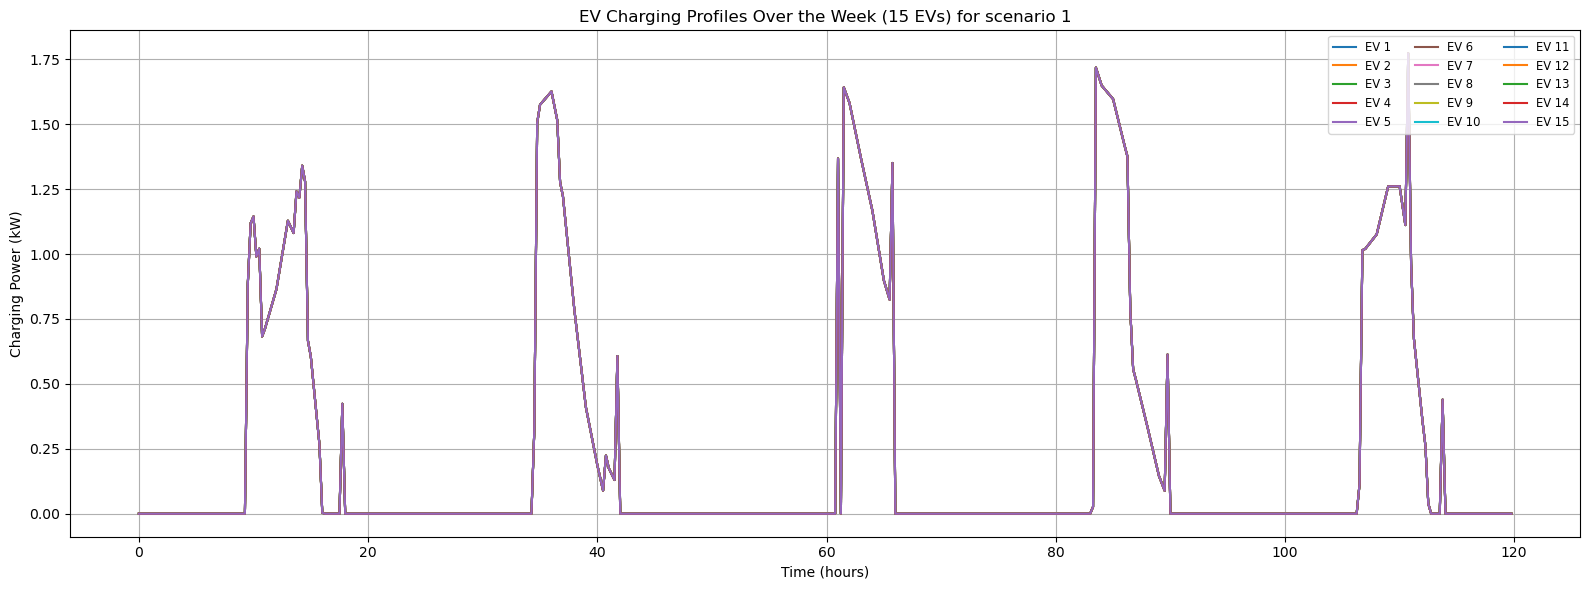

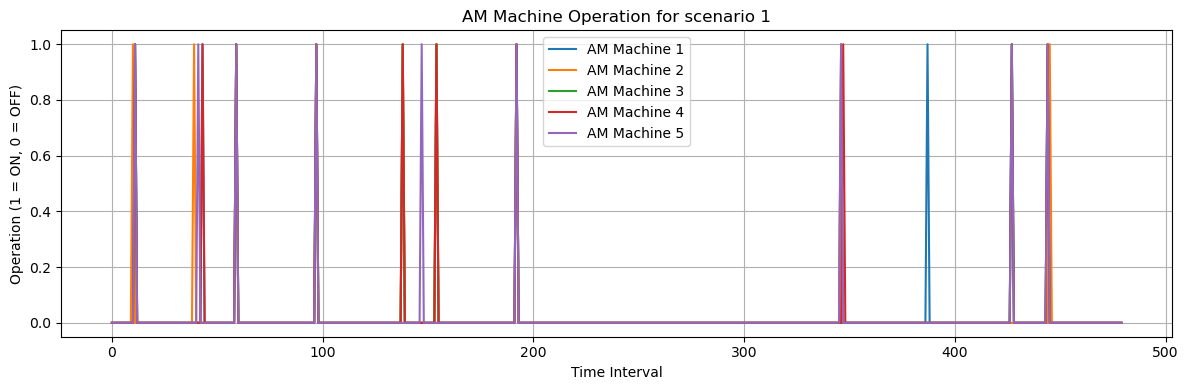

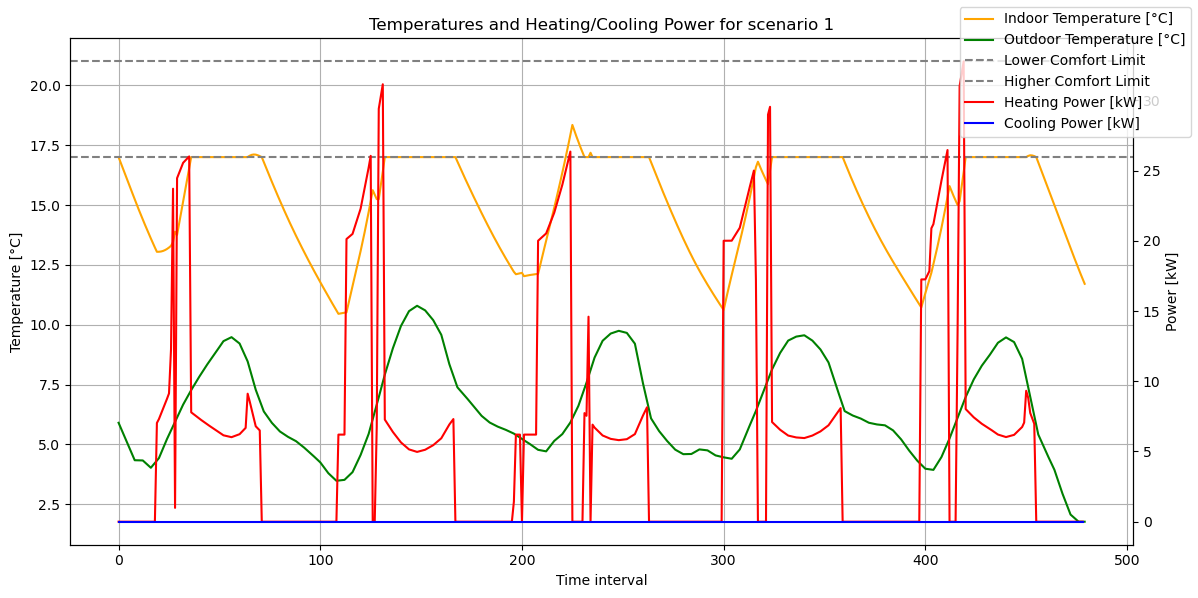

In [ ]:
print("Scenario 1:")
detailed_plots(1,T_in_1,p_ev_1,pc_1, ph_1, x_1, days, slots_per_day, n_AMM, AMM, horizon, num_evs)

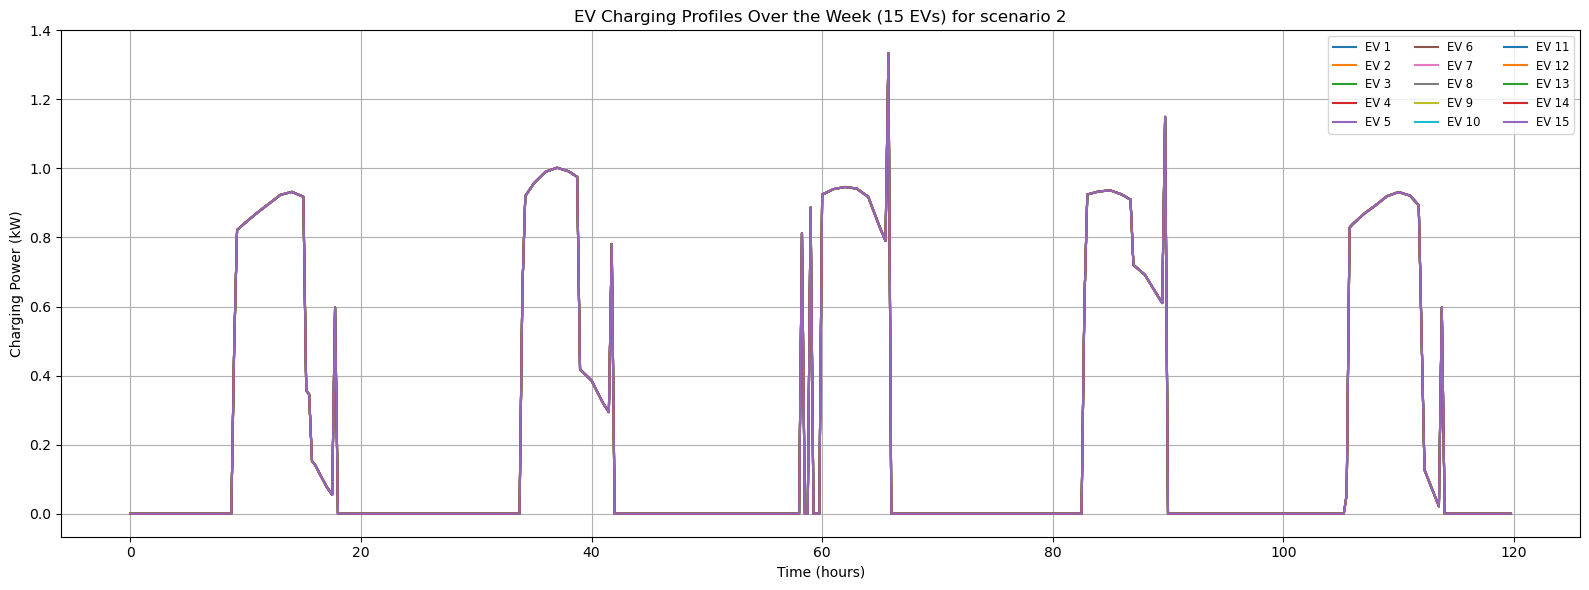

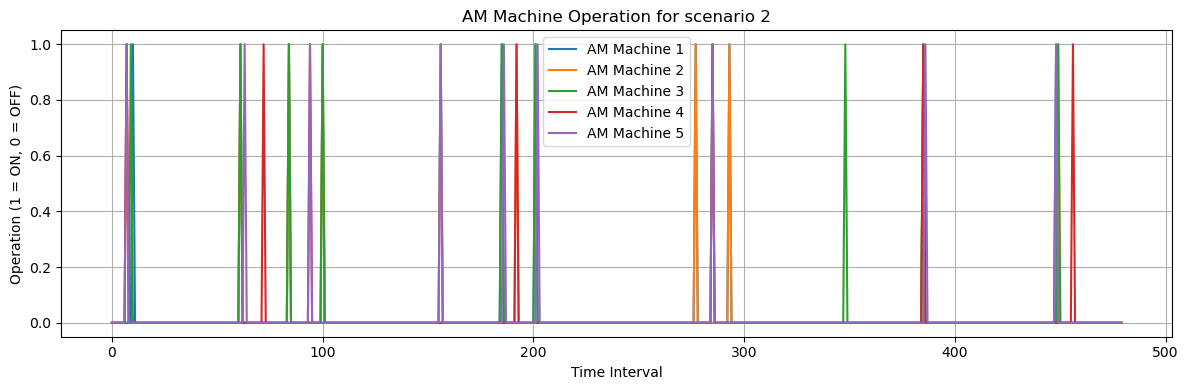

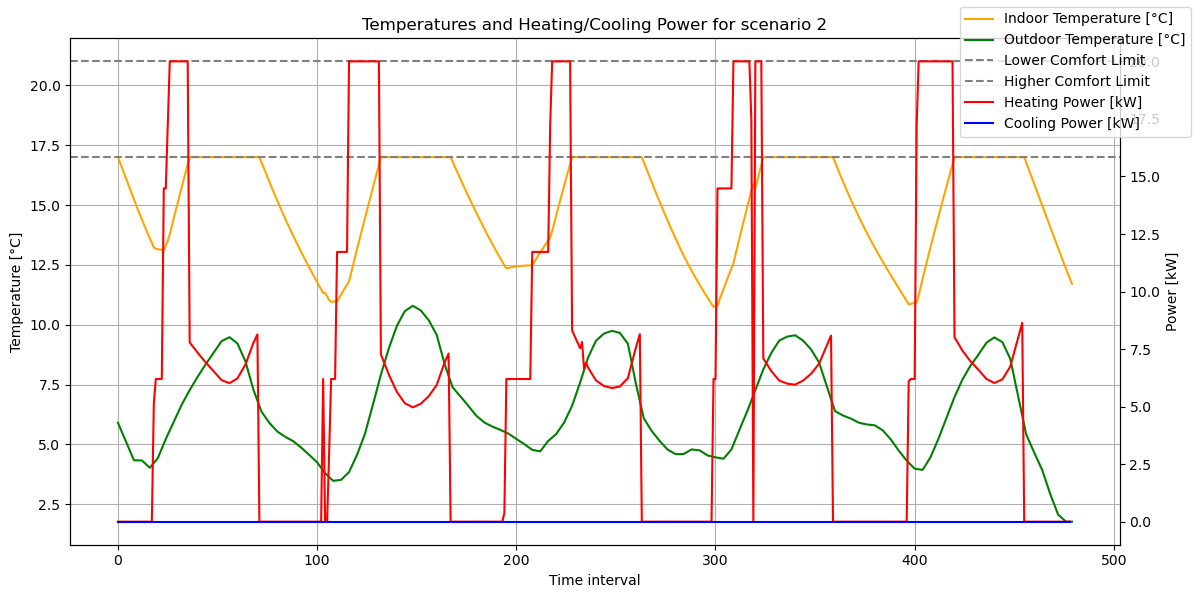

In [ ]:
print("Scenario 2:")
detailed_plots(2,T_in_2,p_ev_2,pc_2, ph_2, x_2, days, slots_per_day, n_AMM, AMM, horizon, num_evs)

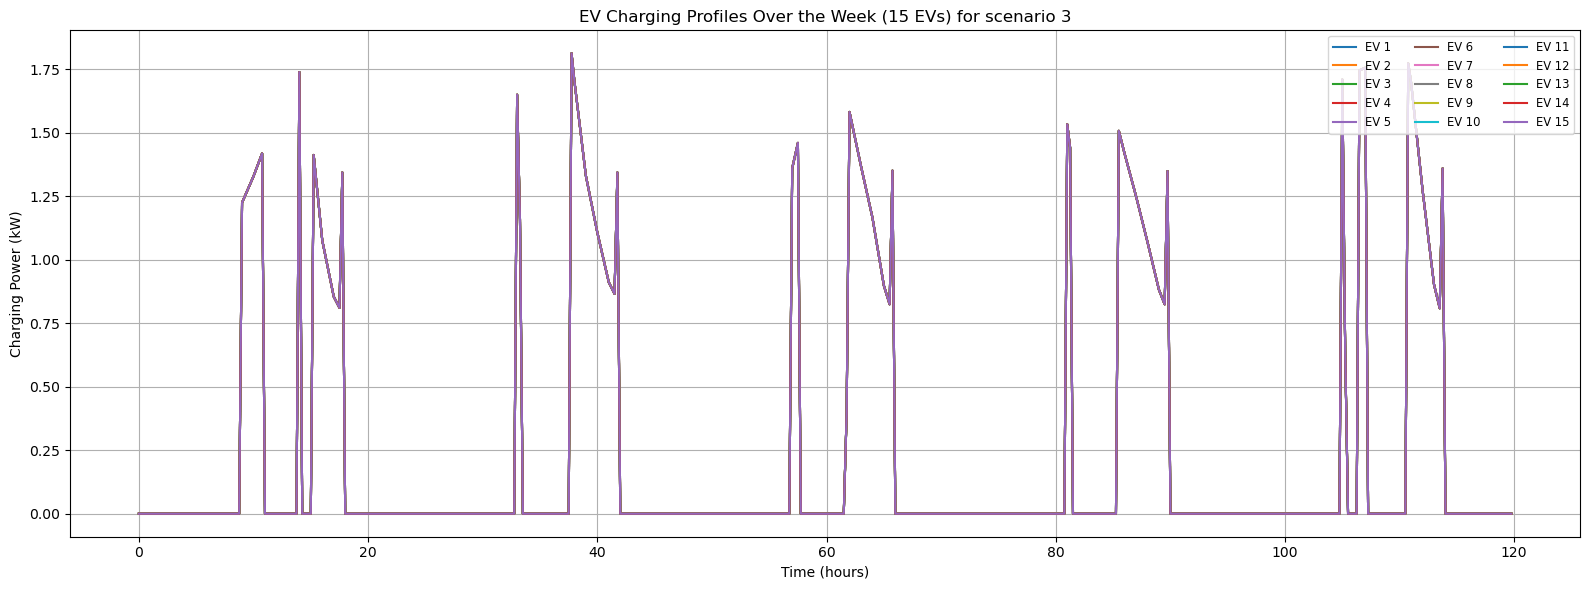

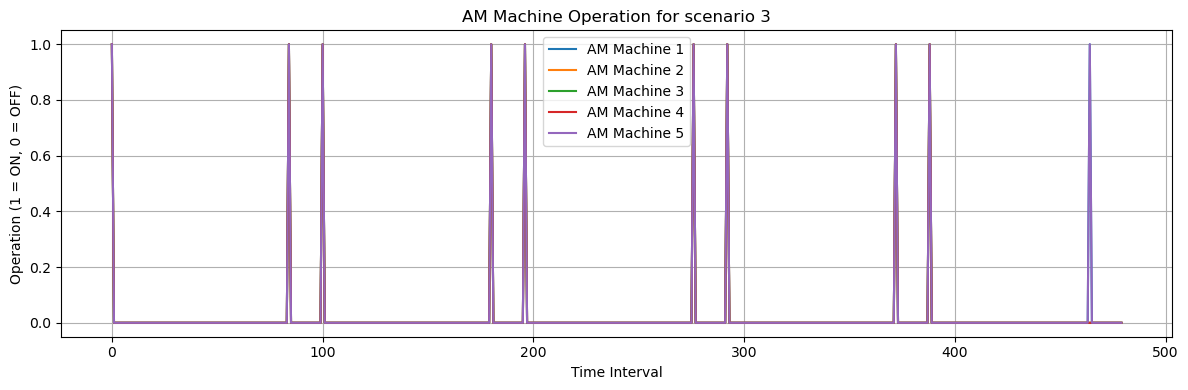

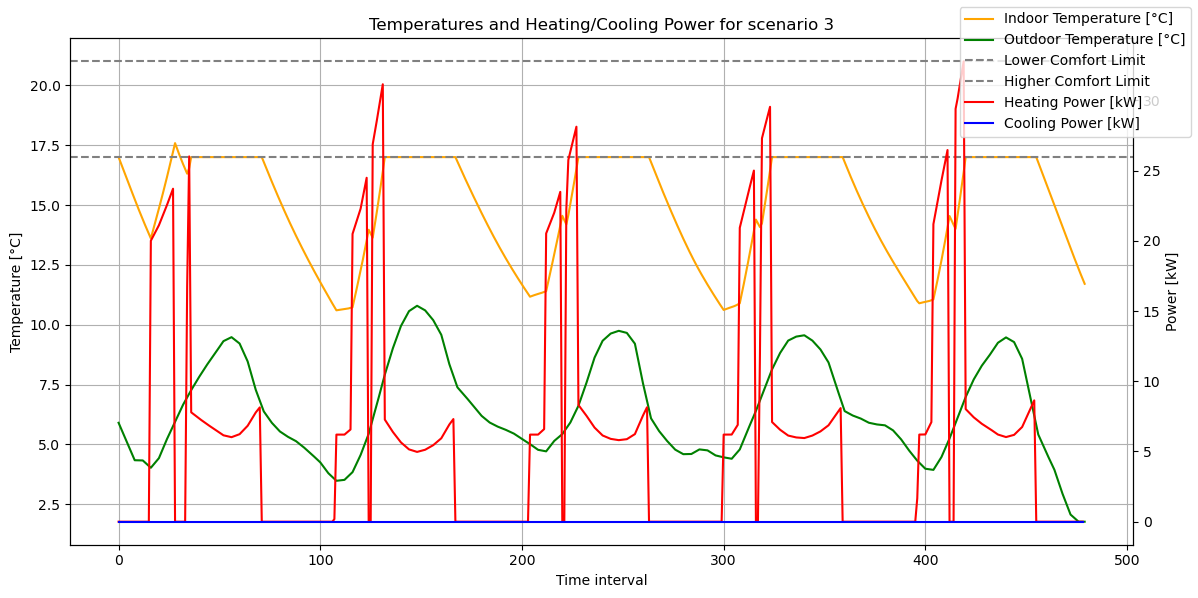

In [ ]:
print("Scenario 3:")
detailed_plots(3,T_in_3,p_ev_3,pc_3, ph_3, x_3, days, slots_per_day, n_AMM, AMM, horizon, num_evs)

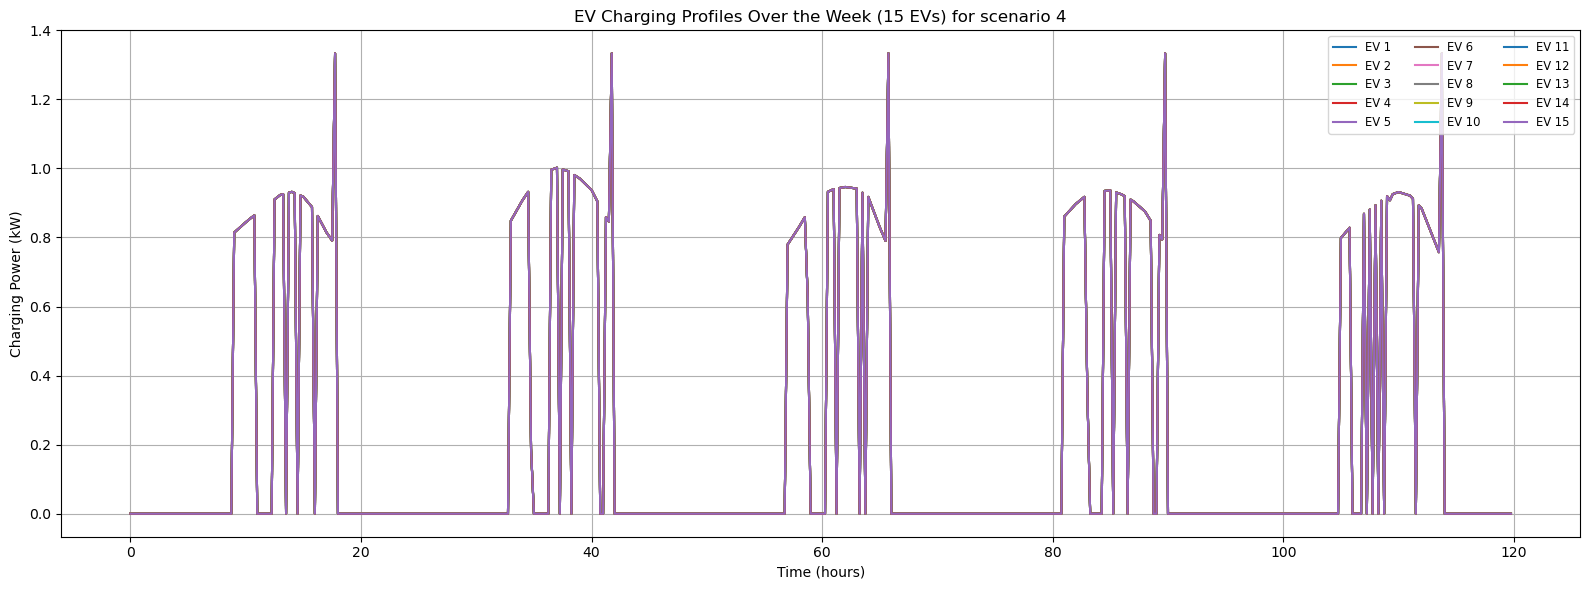

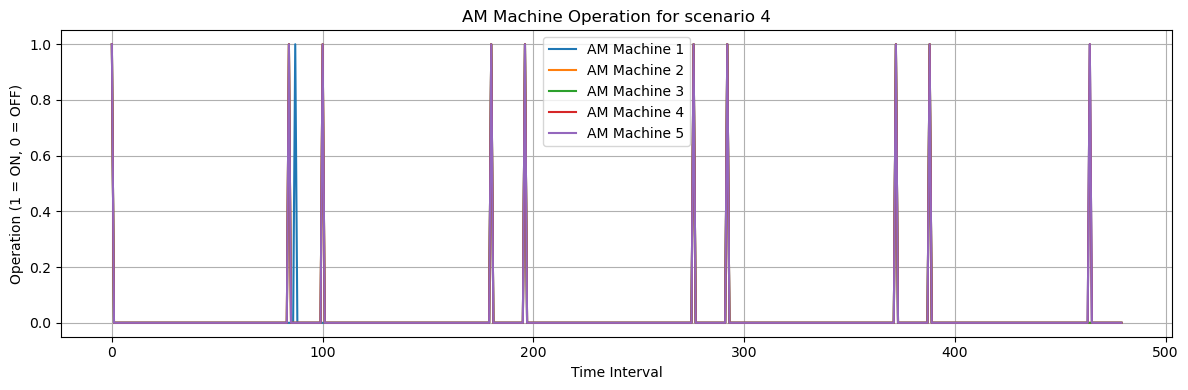

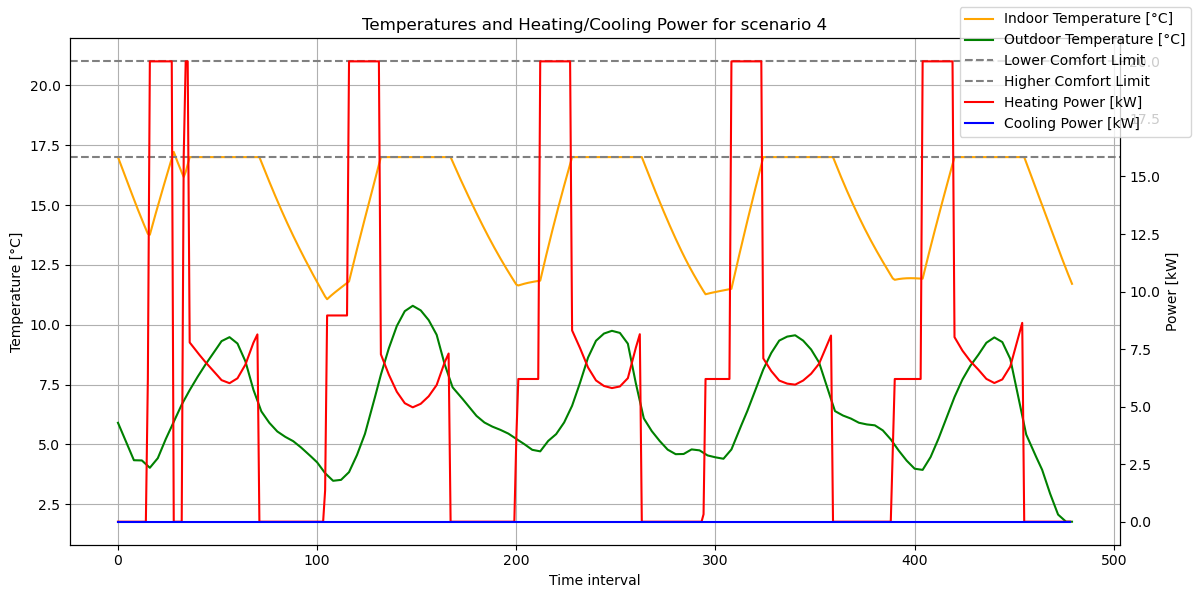

In [ ]:
print("Scenario 4:")
detailed_plots(4,T_in_4,p_ev_4,pc_4, ph_4, x_4, days, slots_per_day, n_AMM, AMM, horizon, num_evs)